# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import  make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score ,median_absolute_error
from sklearn.linear_model  import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.preprocessing import Normalizer,StandardScaler

from sklearn.model_selection import KFold

from sklearn.model_selection import PredefinedSplit

from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from sklearn.metrics import get_scorer_names

In [4]:
np.random.seed(42)

## Загрузка и подготовка данных

In [5]:
def explore_dataframe_text(df):
    # выводим первые 5 строк датафрейма
    # выводим первые 5 строк датафрейма
    print("*" * 50)
    print("Первые 5 строк датафрейма:")
    print("*" * 50)
    display(df.head())
    print()
    
    # выводим информацию о типах данных и количестве пропущенных значений
    print("*" * 50)
    print("Информация о данных:")
    print("*" * 50)
    print()
    print(df.info())
    print()
    
    # выводим описание статистических характеристик числовых столбцов
    print("*" * 50)
    print("Статистические характеристики числовых столбцов:")
    print("*" * 50)
    print()

    display(df.describe())
    print()
    
    # выводим сколько дубликатов найдено
    print("*" * 50)
    print("Кол-во дубликатов")
    print("*" * 50)
    print(df['id'].duplicated().sum())
    print('\n\n')
    
    # выводим все дублирующиееся id
    print("*" * 50)
    print("Вывод дублированных данных")
    print("*" * 50)
    duplicated_objects = df[df['id'].isin(df[df['id'].duplicated()]['id'])].sort_values(by='id')
    display(duplicated_objects)
    print()
    
    # Проверка на то являются ли они полными дубликатами
    print("*" * 50)
    print("Кол-во строк являющихся полнымы дубликатами\n")
    print("*" * 50)
    print(duplicated_objects.duplicated().sum())
    
    if duplicated_objects.duplicated().sum() == 0 : 
        print("Объекты не являются полными дубликатами\n")
    else:
        print("Есть полные дубликаты: \n")
        display(duplicated_objects[duplicated_objects.duplicated()])
    
    print()
    
    
    #выводим корреляцию между признаками 
    print("*" * 50)
    print("Корреляция между признаками ")
    print("*" * 50)
    display(df.corr())
    print()
    
    
    

In [6]:
def draw_boxplot_kde(df):
    
    plt.figure(figsize=(15,8))
    sns.set_style("darkgrid")
    sns.despine()
    
    for i in df.select_dtypes(exclude='object'):
        fig, axs = plt.subplots(ncols=2, figsize=(15, 7))
        sns.boxplot(x=i, data=df, ax=axs[0],notch=True)
        axs[0].set_title("Boxplot")
        sns.kdeplot(x=i, data=df, ax=axs[1])
        axs[1].set_title("KDE")
        plt.show()

In [7]:
def check_inter_duplication(df0,df1,df2):
    ser= pd.Series(dtype='object')
    
    for i in range(3):   
        if i == 0:
            print("*" * 60)
            print("id из 0 региона, являющиеся дубликатами id из 1 региона\n")
            print("*" * 60)
            unique_id = df0[df0['id'].isin(df1['id'].unique())]['id']
            display(unique_id)
            duplicated_id = df0[df0['id'].duplicated()]['id']
            if df0[df0['id'].duplicated()].isin(unique_id).sum()[0] == 0:
                print("Дубликаты внутри региона не пересекаются с дубликатами между регионами\n")
            else:
                print("Найдены дубликаты внутри региона, пересекающиеся с дубликатами между регионами\n")   
            ser0 = pd.concat([ser,unique_id,duplicated_id])
            
        elif i == 1:
            print("*" * 60)
            print("id из 1 региона, являющиеся дубликатами id из 2 региона\n")
            print("*" * 60)
            unique_id = df1[df1['id'].isin(df2['id'].unique())]['id']
            display(unique_id)
            duplicated_id = df1[df1['id'].duplicated()]['id']
            if df1[df1['id'].duplicated()].isin(unique_id).sum()[0] == 0:
                print("Дубликаты внутри региона не пересекаются с дубликатами между регионами\n")
            else:
                print("Найдены дубликаты внутри региона, пересекающиеся с дубликатами между регионами\n")
            ser1 = pd.concat([ser,unique_id,duplicated_id])
        elif i == 2:
            print("*" * 60)
            print("id из 2 региона, являющиеся дубликатами id из 0 региона\n")
            print("*" * 60)
            unique_id = df2[df2['id'].isin(df0['id'].unique())]['id']
            display(unique_id)
            duplicated_id = df2[df2['id'].duplicated()]['id']
            if df2[df2['id'].duplicated()].isin(unique_id).sum()[0] == 0:
                print("Дубликаты внутри региона не пересекаются с дубликатами между регионами\n")
            else:
                print("Найдены дубликаты внутри региона, пересекающиеся с дубликатами между регионами\n")
            ser2 = pd.concat([ser,unique_id,duplicated_id])
    return [ser0,ser1,ser2]

In [8]:
def replace_indexes(df0, df1, df2, mask0, mask1, mask2):
    df0.loc[mask0, 'id'] = df0.loc[mask0,'id'] + '_d'
    df1.loc[mask1, 'id'] = df1.loc[mask1,'id'] + '_d'
    df2.loc[mask2, 'id'] = df2.loc[mask2,'id'] + '_d'
    return df0, df1, df2

In [9]:
df_geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')

In [10]:
df_geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [11]:
df_geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Регион №0

In [12]:
explore_dataframe_text(df_geo_data_0)

**************************************************
Первые 5 строк датафрейма:
**************************************************


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



**************************************************
Информация о данных:
**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

**************************************************
Статистические характеристики числовых столбцов:
**************************************************



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



**************************************************
Кол-во дубликатов
**************************************************
10



**************************************************
Вывод дублированных данных
**************************************************


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



**************************************************
Кол-во строк являющихся полнымы дубликатами

**************************************************
0
Объекты не являются полными дубликатами


**************************************************
Корреляция между признаками 
**************************************************


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


**Заметка 1**  
- Посмотреть на f2, так как разброс куда сильнее чем у ф1 и ф2,  могут быть выбросы/аномалии  (+ нужно масштабирование )  
- Есть 10 пар которые продублированы по id, так как в заданиb я не нашел ничего, что могло бы объяснить эти дублированные id, то я опираясь на логику делаю вывод что алгоритм присваивающий id не проверял на уникальность, так как за 100000 попасть всего 10 раз  -> поменять id на значения которых в дф нет. Но для возможности поиска я сделаю приставку _d что будет означать что этот ид являлася дубликатом 
- Есть умеренно отрицательная корреляция f0 и f1, f2 и product-> было бы разумно использовать регуляризацию   


<Figure size 1080x576 with 0 Axes>

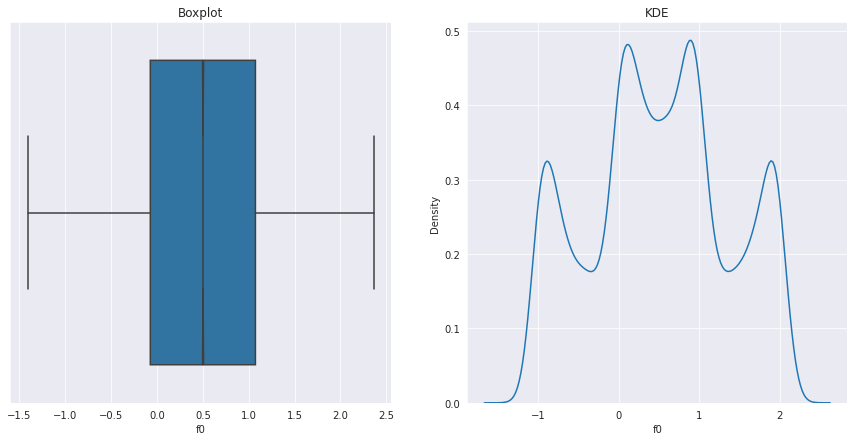

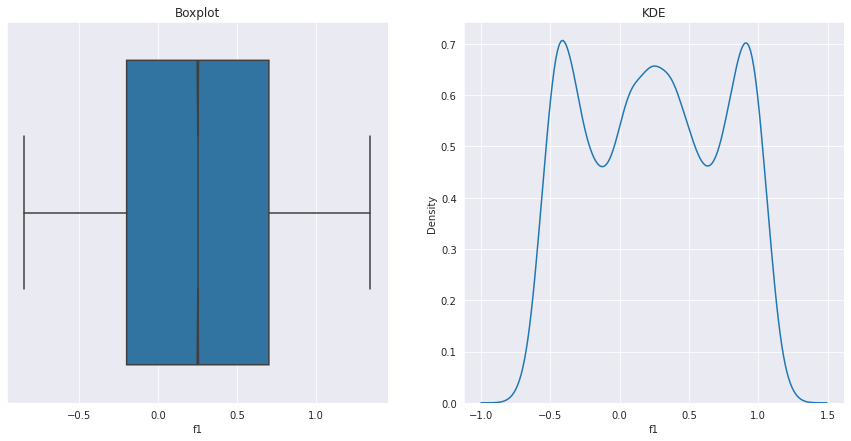

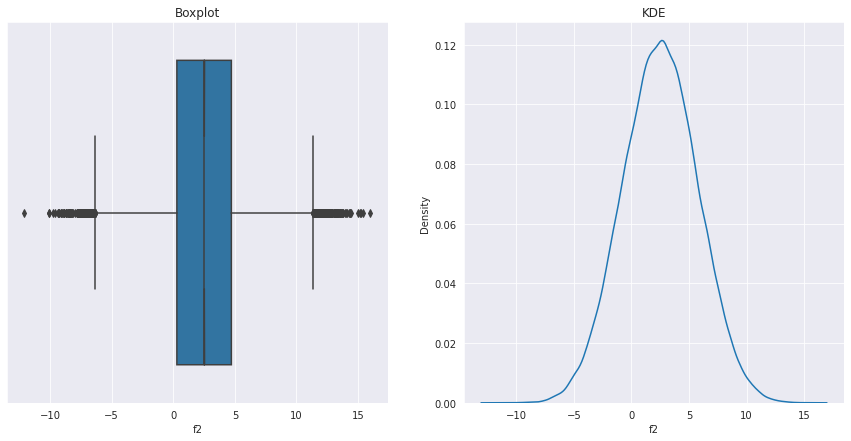

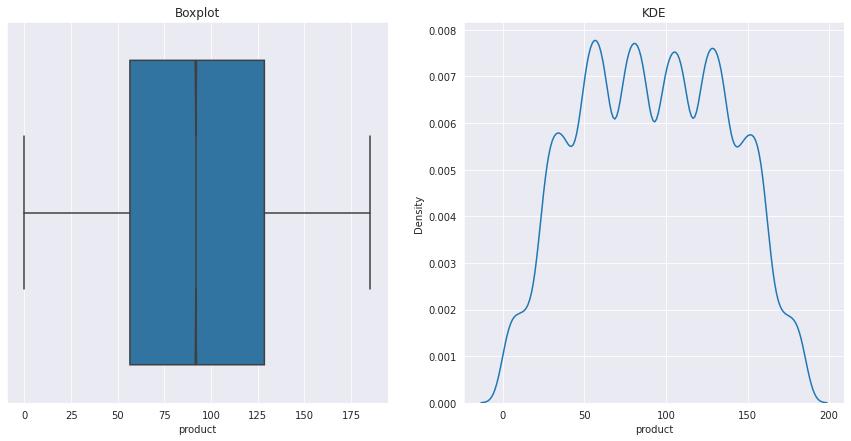

In [13]:
draw_boxplot_kde(df_geo_data_0)



у продукта - нулевых не так много что может дать нам возможность использовать mape

### Регион №1

In [14]:
explore_dataframe_text(df_geo_data_1)

**************************************************
Первые 5 строк датафрейма:
**************************************************


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



**************************************************
Информация о данных:
**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

**************************************************
Статистические характеристики числовых столбцов:
**************************************************



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



**************************************************
Кол-во дубликатов
**************************************************
4



**************************************************
Вывод дублированных данных
**************************************************


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



**************************************************
Кол-во строк являющихся полнымы дубликатами

**************************************************
0
Объекты не являются полными дубликатами


**************************************************
Корреляция между признаками 
**************************************************


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**Заметка 2**  
- Посмотреть на f0  и f1  внимательно так как по describe шанс на выбросы очень велик  
- Есть 4 пары которые продублированы по id, так как в заданиb я не нашел ничего, что могло бы объяснить эти дублированные id, то я опираясь на логику делаю вывод что алгоритм присваивающий id не проверял на уникальность, так как за 100000 попасть всего 4 раза  -> поменять id на значения которых в дф нет. Но для возможности поиска я сделаю приставку _d что будет означать что этот ид являлася дубликатом   
-  f2 и product имеют очень сильную положительную корреляцию -> сделать проверку на валидации как модель поведет себя при избавлении от одного из признаков   



<Figure size 1080x576 with 0 Axes>

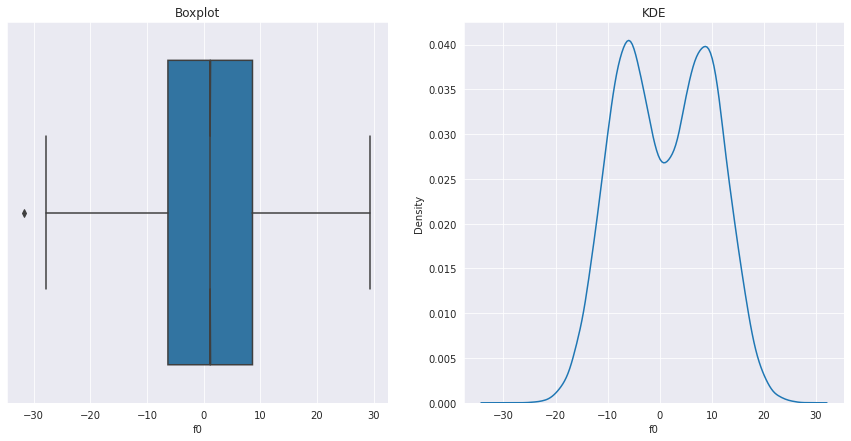

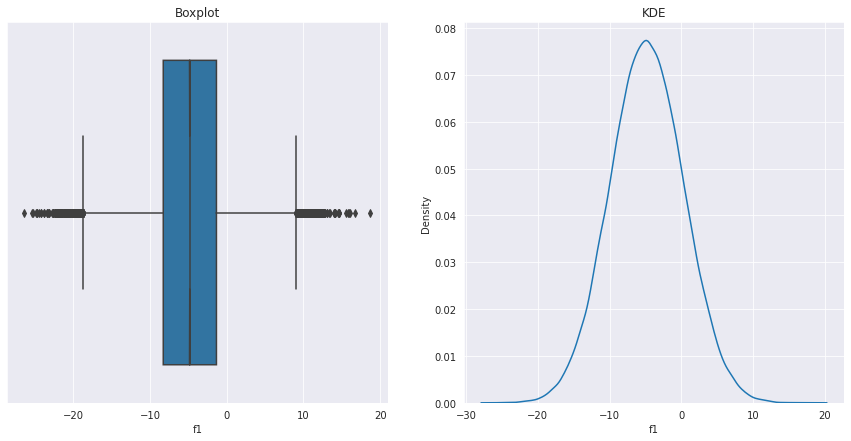

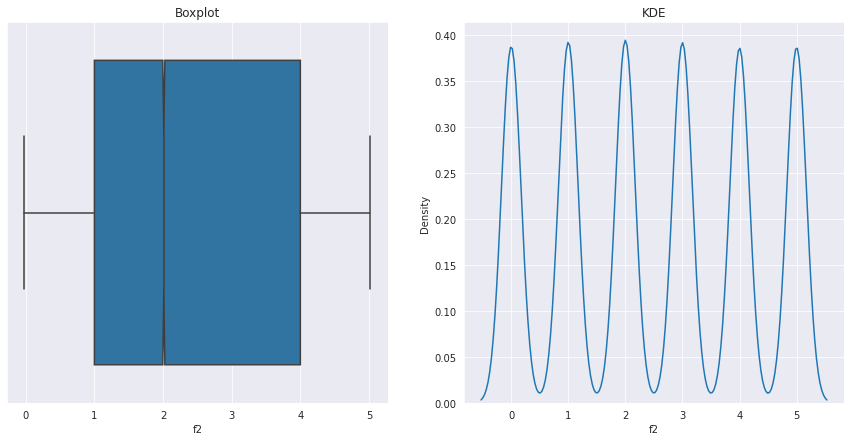

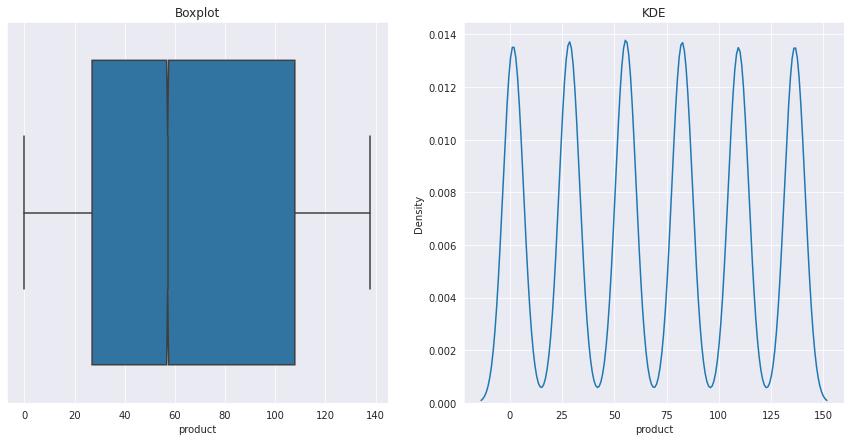

In [15]:
draw_boxplot_kde(df_geo_data_1)

а вот тут уже по продакту неприятно в 0 не мало значений

### Регион №2

In [16]:
explore_dataframe_text(df_geo_data_2)

**************************************************
Первые 5 строк датафрейма:
**************************************************


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



**************************************************
Информация о данных:
**************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

**************************************************
Статистические характеристики числовых столбцов:
**************************************************



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



**************************************************
Кол-во дубликатов
**************************************************
4



**************************************************
Вывод дублированных данных
**************************************************


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641



**************************************************
Кол-во строк являющихся полнымы дубликатами

**************************************************
0
Объекты не являются полными дубликатами


**************************************************
Корреляция между признаками 
**************************************************


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Заметка 3**  
- Построить boxplot, так как тоже есть аномальные значения
- Есть 4 пары которые продублированы по id, так как в заданиb я не нашел ничего, что могло бы объяснить эти дублированные id, то я опираясь на логику делаю вывод что алгоритм присваивающий id не проверял на уникальность, так как за 100000 попасть всего 4 раза  -> поменять id на значения которых в дф нет. Но для возможности поиска я сделаю приставку _d что будет означать что этот ид являлася дубликатом   
-  f2 и product имеют умеренно положительную корреляцию -> регуляризация  


<Figure size 1080x576 with 0 Axes>

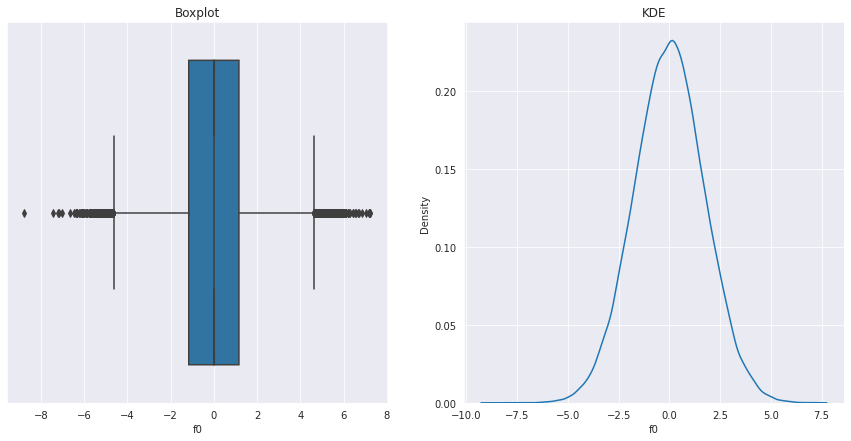

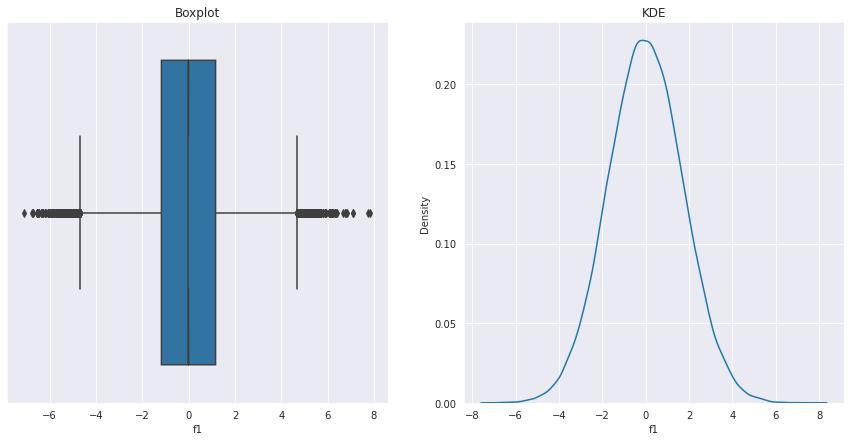

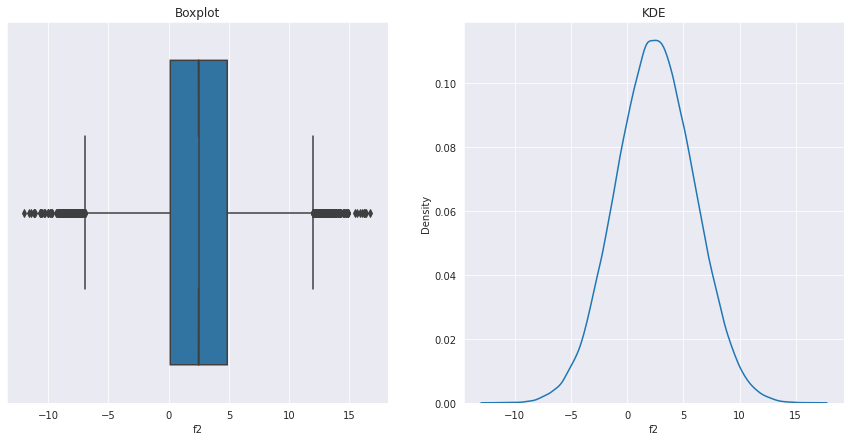

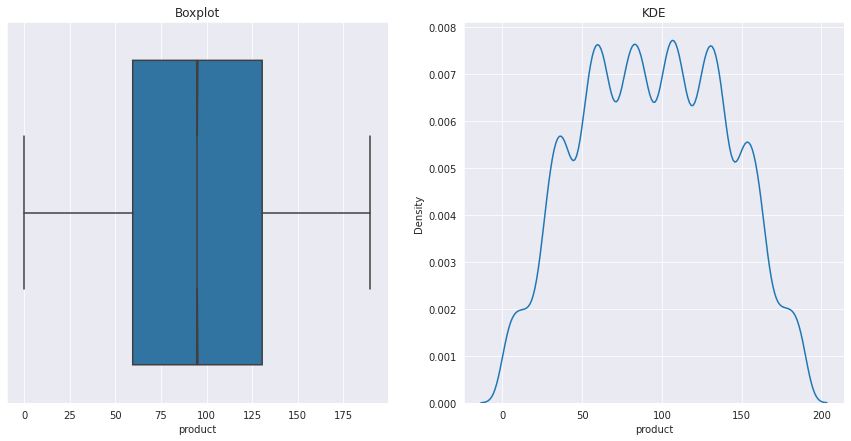

In [17]:
draw_boxplot_kde(df_geo_data_2)

в 0 немного 

### Дубли между регионами

In [18]:
exchange = check_inter_duplication(df_geo_data_0,df_geo_data_1,df_geo_data_2)


************************************************************
id из 0 региона, являющиеся дубликатами id из 1 региона

************************************************************


1419     Q64YW
14777    CXJ2r
44057    Y2udP
44242    g3RRG
66852    mpZhE
71547    L1Fdm
75589    it2OW
86152    gnA83
87474    Mp3uM
93783    pGQRI
Name: id, dtype: object

Дубликаты внутри региона не пересекаются с дубликатами между регионами

************************************************************
id из 1 региона, являющиеся дубликатами id из 2 региона

************************************************************


28877    TAqwC
38405    uMqiK
44738    D8TNs
92366    g2I86
Name: id, dtype: object

Дубликаты внутри региона не пересекаются с дубликатами между регионами

************************************************************
id из 2 региона, являющиеся дубликатами id из 0 региона

************************************************************


7260     uSye4
9042     LhkAh
13672    i2csb
17551    TXPOv
27380    2tyMi
27885    wqgPo
31306    H2jd8
48472    scFN4
49106    lFHA5
50308    rAJA6
57741    Suyut
72896    5ssQt
79311    kpKGs
82577    eVdPR
87965    tgOl6
91259    G6k8A
97706    PyNp5
Name: id, dtype: object

Дубликаты внутри региона не пересекаются с дубликатами между регионами



In [19]:
indexes_0 = exchange[0].reset_index()['index']

In [20]:
indexes_1 = exchange[1].reset_index()['index']

In [21]:
indexes_2 = exchange[2].reset_index()['index']

In [22]:
df0,df1,df2 = replace_indexes(df_geo_data_0,df_geo_data_1,df_geo_data_2,indexes_0,indexes_1,indexes_2)

In [23]:
check_inter_duplication(df0,df1,df2)

************************************************************
id из 0 региона, являющиеся дубликатами id из 1 региона

************************************************************


Series([], Name: id, dtype: object)

Дубликаты внутри региона не пересекаются с дубликатами между регионами

************************************************************
id из 1 региона, являющиеся дубликатами id из 2 региона

************************************************************


Series([], Name: id, dtype: object)

Дубликаты внутри региона не пересекаются с дубликатами между регионами

************************************************************
id из 2 региона, являющиеся дубликатами id из 0 региона

************************************************************


Series([], Name: id, dtype: object)

Дубликаты внутри региона не пересекаются с дубликатами между регионами



[Series([], dtype: object),
 Series([], dtype: object),
 Series([], dtype: object)]

Дубликаты убраны

In [24]:
df0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [25]:
df0.set_index('id', inplace=True)

In [26]:
df1.set_index('id', inplace=True)

In [27]:
df2.set_index('id', inplace=True)

In [28]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [29]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


In [30]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB


### Вывод


1. Есть умеренно отрицательная корреляция f0 и f1, f2 и product-> было бы разумно использовать регуляризацию


2. f2 и product имеют очень сильную положительную корреляцию -> сделать проверку на валидации как модель поведет себя при избавлении от одного из признаков


3. f2 и product имеют умеренно положительную корреляцию 

По графикам можно заметить что есть значения выходящие за усы, трогать не зная что это конкретно за признаки - может привести к неожиданному результату , но использованеи регуляризации и масштабирования скорее всего смогут решить эту проблему, так же можно отчетливо наблюдать как корреляция в п.2 на них отображена  

Так же столбец с индексами был перемещен в индексы после изменения дублирующихся индексов  на id + _d   
  


## Обучение и проверка модели

In [31]:
def add_features(df, cols):
    for col in cols:
                
        df[f'sin_{col}'] = np.cos(df[col])
        
        df[f'^2_{col}'] = (df[col])**2 * 0.3
        
        df[f'^3_{col}'] = (df[col])**3 * 0.191
        
        df[f'e_{col}'] = np.exp((df[col])) * np.sin(df[col])/(df[col]**2+1)
    return df

In [32]:
def my_train_test(df,list_col,key): 
    scaler = StandardScaler() #StandardScaler
    model = LinearRegression()
    X = df.drop('product',axis=1)
    X = add_features(X, list_col)
    y = df['product']
    pipline = make_imblearn_pipeline(scaler, model)
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.75,random_state=42)
    X.info()
    plt.figure(figsize=(12,7))
    sns.heatmap(X.corr(), cmap="YlGnBu")
    plt.show()
    
    
    if key:
        alphas = np.linspace(30, 45, num=15)
    else:
        alphas = np.linspace(0.1, 0.9, num=9)

    
    param_grid = [
    {'linearregression': [LinearRegression()] },
    
    {'linearregression': [Ridge(random_state=42)], 
                'linearregression__alpha': alphas }, 
    
    {'linearregression': [Lasso(random_state=42)], 
             'linearregression__alpha': alphas },
    {'linearregression': [ElasticNet(random_state=42)], 
             'linearregression__l1_ratio' : [0.3, 0.7]}
    
    ]
    
    
    grid_search = GridSearchCV(pipline, 
                               param_grid, 
                               cv=5, 
                               scoring = ['neg_mean_squared_error', 
                                          'r2', 
                                          'neg_mean_absolute_error'],
                               
                               refit='neg_mean_squared_error'
                              )
    
    grid_search.fit(X_train, y_train)
    
    
    pred = grid_search.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    rmse = mse**(1/2)
    mae = median_absolute_error(y_test,pred)
    
    
    return {'predictions' : {'data_predictions' : pred, 'mean_pred' : np.mean(pred)}, 
            'true_values' :{'data_y_test' : y_test, 'mean_y_test' : y_test.mean()},
            'metrics': {'MSE': mse, 'RMSE':rmse, 'MAE':mae}, 
            'config': {'best_params' :grid_search.best_params_ , 
                       'best_score' : grid_search.best_score_, 
                       'cv_results_' : grid_search.cv_results_
                      } 
           }

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f0      100000 non-null  float64
 1   f1      100000 non-null  float64
 2   f2      100000 non-null  float64
 3   sin_f0  100000 non-null  float64
 4   ^2_f0   100000 non-null  float64
 5   ^3_f0   100000 non-null  float64
 6   e_f0    100000 non-null  float64
 7   sin_f1  100000 non-null  float64
 8   ^2_f1   100000 non-null  float64
 9   ^3_f1   100000 non-null  float64
 10  e_f1    100000 non-null  float64
 11  sin_f2  100000 non-null  float64
 12  ^2_f2   100000 non-null  float64
 13  ^3_f2   100000 non-null  float64
 14  e_f2    100000 non-null  float64
dtypes: float64(15)
memory usage: 14.2+ MB


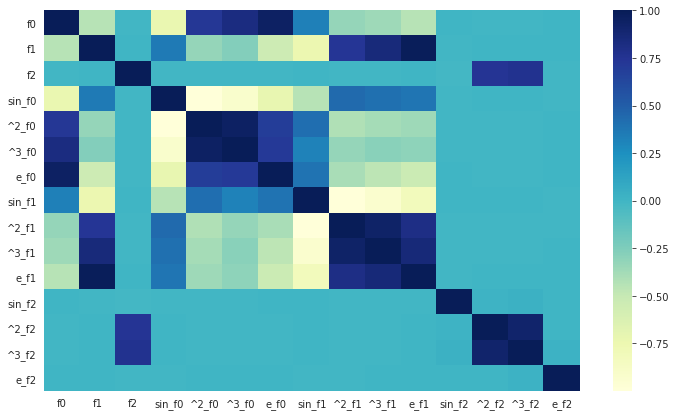

In [33]:
region0_predict = my_train_test(df0, ['f0','f1','f2'], False)

In [34]:
region0_predict

{'predictions': {'data_predictions': array([102.81259969,  75.69108137, 115.73802222, ...,  81.92942465,
          87.74100742,  99.72689863]),
  'mean_pred': 92.4510125909199},
 'true_values': {'data_y_test': id
  7C6bA    122.073350
  dVxsn     48.738540
  1Gm3l    131.338088
  Nzg1t     88.327757
  Z7b4F     36.959266
              ...    
  pXFCs    148.821520
  tf6nq    123.454003
  pv8T0     91.945213
  nol4A    149.295563
  MUye1     57.244039
  Name: product, Length: 25000, dtype: float64,
  'mean_y_test': 92.32595637084387},
 'metrics': {'MSE': 1391.4767329115548,
  'RMSE': 37.30250303815489,
  'MAE': 27.397999691919633},
 'config': {'best_params': {'linearregression': Ridge(alpha=0.6, random_state=42),
   'linearregression__alpha': 0.6},
  'best_score': -1385.1216254595693,
  'cv_results_': {'mean_fit_time': array([0.14392262, 0.14470119, 0.12966805, 0.1312963 , 0.13166771,
          0.12739596, 0.17694583, 0.13508286, 0.14008999, 0.12702923,
          3.8198802 , 6.79777265,

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f0      100000 non-null  float64
 1   f1      100000 non-null  float64
 2   f2      100000 non-null  float64
 3   sin_f0  100000 non-null  float64
 4   ^2_f0   100000 non-null  float64
 5   ^3_f0   100000 non-null  float64
 6   e_f0    100000 non-null  float64
 7   sin_f1  100000 non-null  float64
 8   ^2_f1   100000 non-null  float64
 9   ^3_f1   100000 non-null  float64
 10  e_f1    100000 non-null  float64
 11  sin_f2  100000 non-null  float64
 12  ^2_f2   100000 non-null  float64
 13  ^3_f2   100000 non-null  float64
 14  e_f2    100000 non-null  float64
dtypes: float64(15)
memory usage: 14.2+ MB


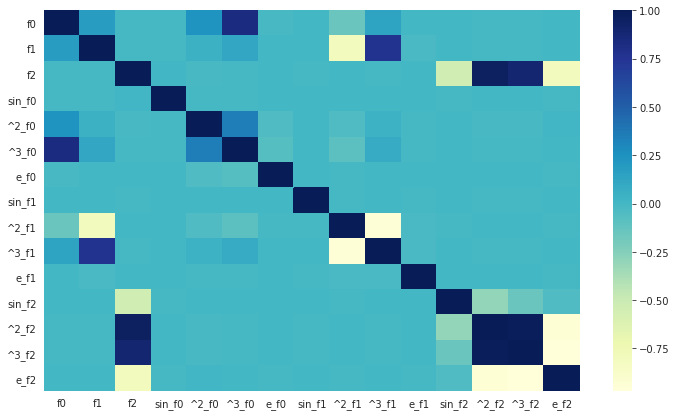

In [35]:
region1_predict = my_train_test(df1, ['f0','f1','f2'], False)

In [36]:
region1_predict

{'predictions': {'data_predictions': array([  0.57121369,  53.41096633, 134.79952319, ...,  26.8062185 ,
         110.0039042 , 135.09928926]),
  'mean_pred': 68.7171641695545},
 'true_values': {'data_y_test': id
  fYVDK      0.000000
  3SQcq     53.906522
  hQ1gJ    134.766305
  Y4vux    107.813044
  H1NUw      0.000000
              ...    
  Vn3pL    107.813044
  zZe7H     53.906522
  iefIy     26.953261
  CFT5B    110.992147
  cQudG    134.766305
  Name: product, Length: 25000, dtype: float64,
  'mean_y_test': 68.72538074722745},
 'metrics': {'MSE': 0.6182907317469077,
  'RMSE': 0.7863146518709337,
  'MAE': 0.3388047544789927},
 'config': {'best_params': {'linearregression': LinearRegression()},
  'best_score': -0.6187507911340028,
  'cv_results_': {'mean_fit_time': array([0.12431984, 0.11357079, 0.14573646, 0.14893017, 0.13430958,
          0.1333292 , 0.14906869, 0.1336565 , 0.16112533, 0.1737021 ,
          0.14037552, 0.1519001 , 0.13756709, 0.12941151, 0.12743206,
          0.

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f0      100000 non-null  float64
 1   f1      100000 non-null  float64
 2   f2      100000 non-null  float64
 3   sin_f0  100000 non-null  float64
 4   ^2_f0   100000 non-null  float64
 5   ^3_f0   100000 non-null  float64
 6   e_f0    100000 non-null  float64
 7   sin_f1  100000 non-null  float64
 8   ^2_f1   100000 non-null  float64
 9   ^3_f1   100000 non-null  float64
 10  e_f1    100000 non-null  float64
 11  sin_f2  100000 non-null  float64
 12  ^2_f2   100000 non-null  float64
 13  ^3_f2   100000 non-null  float64
 14  e_f2    100000 non-null  float64
dtypes: float64(15)
memory usage: 14.2+ MB


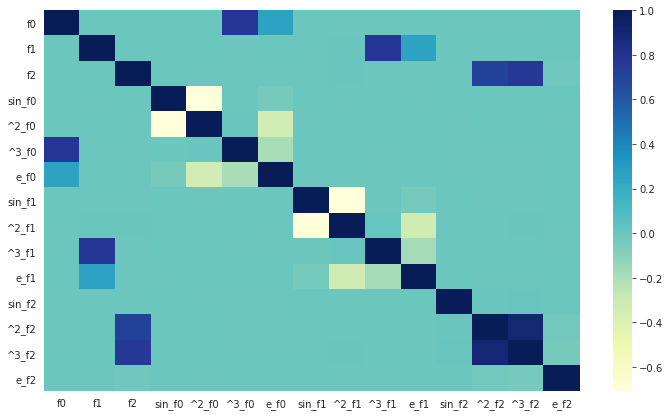

In [37]:
region2_predict = my_train_test(df2, ['f0','f1','f2'], True)

In [38]:
region2_predict

{'predictions': {'data_predictions': array([110.08144227,  89.12205974,  61.68461185, ...,  72.57439703,
          77.63817287,  83.42888786]),
  'mean_pred': 94.74272380870717},
 'true_values': {'data_y_test': id
  sPjbT    117.441301
  1u4uo     47.841249
  kZ6HO     45.883483
  gCZGK    139.014608
  rqJHx     84.004276
              ...    
  hMnQH     40.797226
  KGq37     87.144239
  CKCjb     52.039812
  ANcQx    136.961454
  AarNF    109.173206
  Name: product, Length: 25000, dtype: float64,
  'mean_y_test': 95.15099907171961},
 'metrics': {'MSE': 1461.8260647707182,
  'RMSE': 38.233834031793336,
  'MAE': 28.388251161736775},
 'config': {'best_params': {'linearregression': Ridge(alpha=45.0, random_state=42),
   'linearregression__alpha': 45.0},
  'best_score': -1452.2024607152634,
  'cv_results_': {'mean_fit_time': array([0.12929263, 0.12578769, 0.15955462, 0.14960637, 0.14701123,
          0.16013241, 0.13827686, 0.14538388, 0.13479466, 0.13399534,
          0.1583549 , 0.13508

In [39]:
print(f"Метрики для 0 региона: \nMSE = {region0_predict['metrics']['MSE']}  \nMAE = {region0_predict['metrics']['MAE']}")
print(f"RMSE = {region0_predict['metrics']['RMSE']}")

Метрики для 0 региона: 
MSE = 1391.4767329115548  
MAE = 27.397999691919633
RMSE = 37.30250303815489


In [40]:
print(f"Метрики для 1 региона: \nMSE = {region1_predict['metrics']['MSE']}  \nMAE = {region1_predict['metrics']['MAE']}")
print(f"RMSE = {region1_predict['metrics']['RMSE']}")

Метрики для 1 региона: 
MSE = 0.6182907317469077  
MAE = 0.3388047544789927
RMSE = 0.7863146518709337


In [41]:
print(f"Метрики для 2 региона: \nMSE = {region2_predict['metrics']['MSE']}  \nMAE = {region2_predict['metrics']['MAE']}")
print(f"RMSE = {region2_predict['metrics']['RMSE']}")

Метрики для 2 региона: 
MSE = 1461.8260647707182  
MAE = 28.388251161736775
RMSE = 38.233834031793336


Так как не было больших хвостов то оптимизировали MSE а не MAE  

Еще с 1 первого пункта было понятно, что слишком сильная линейная зависимость между таргетом и признаком даст очень хорошие показатели по ошибке, MAE, RMSE, MSE близки к нулю  

Так же после добавления фич были улучшены показатели ошибок у 0 и 2 региона до RMSE_0 = 37.3 MAE_0 = 27.398 и RMSE_2 = 38.23 MAE_2 = 28.388 

В двух случаях $L_2$ регуляризация отработала лучше, но логично, что в 1ом регионе обычная линейная регрессия без регуляризации показала лучший результат, но так же это может быть свзяано с наличием меньшего шума $\epsilon$

RMSE и MAE- показывает насколько сильно прогнозы модели отличаются от фактических значений в среднем 

Метрики для 0 региона:   
MSE = 1391.4767329115548    
MAE = 27.397999691919633  
RMSE = 37.30250303815489  

Метрики для 1 региона:   
MSE = 0.6182907317469077    
MAE = 0.3388047544789927  
RMSE = 0.7863146518709337  

Метрики для 2 региона:   
MSE = 1461.8260647707182    
MAE = 28.388251161736775  
RMSE = 38.233834031793336  

## Подготовка к расчёту прибыли

In [42]:
predictions_reg0 = pd.Series(region0_predict['predictions']['data_predictions'])
predictions_reg1 = pd.Series(region1_predict['predictions']['data_predictions'])
predictions_reg2 = pd.Series(region2_predict['predictions']['data_predictions'])

true_values0 = pd.DataFrame(region0_predict['true_values']['data_y_test'])
true_values1 = pd.DataFrame(region1_predict['true_values']['data_y_test'])
true_values2 = pd.DataFrame(region2_predict['true_values']['data_y_test'])

true_values0 = true_values0.reset_index()['product']
true_values1 = true_values1.reset_index()['product']
true_values2 = true_values2.reset_index()['product']



BUDGET = 10**10 

MONEY_PER_BARREL = 45 * 10**4

NUMBER_OF_POINTS_STUDIED = 500 
NUMBER_OF_SELECTED_POINTS = 200

probability_of_losses = 0.025

In [43]:
true_values0

0        122.073350
1         48.738540
2        131.338088
3         88.327757
4         36.959266
            ...    
24995    148.821520
24996    123.454003
24997     91.945213
24998    149.295563
24999     57.244039
Name: product, Length: 25000, dtype: float64

In [44]:
min_oil_wells = BUDGET/MONEY_PER_BARREL
min_oil_wells

22222.222222222223

In [45]:
BUDGET/NUMBER_OF_SELECTED_POINTS/MONEY_PER_BARREL

111.11111111111111

In [46]:
mean_pr0 = predictions_reg0.mean()
mean_pr1 = predictions_reg1.mean()
mean_pr2 = predictions_reg2.mean()


In [47]:
print(f'Средняя добыча региона 0 : {mean_pr0} \nСредняя добыча региона 1 : {mean_pr1} \nСредняя добыча региона 2 : {mean_pr2}')

Средняя добыча региона 0 : 92.4510125909199 
Средняя добыча региона 1 : 68.7171641695545 
Средняя добыча региона 2 : 94.74272380870717


В каждом из регионов средний объем запасов в скважинах не соответствует требованиям, чтобы достичь необходимых объемов производства при заданных ограничениях бюджета и количества скважин. 

Мы должны брать в учет что ближайшие к порогу - 0 и 2 регионы 92.45 и 94.74 соответственно 

## Расчёт прибыли и рисков 

state = np.random.RandomState(42)

In [55]:
def calculate_profit(preds, targets, num_wells):
    preds_sort = preds.sort_values(ascending=False)

    selected_items = targets[preds_sort.index][:num_wells]
    total_vol = selected_items.sum()
    return total_vol * MONEY_PER_BARREL - BUDGET

In [56]:
def calculate_profit_risk(preds, targets, num_wells):
    profits = []
    for i in range(1000):
        target_subsample = targets.sample(num_wells,replace=True,random_state=state)
        
        pred_subsample = preds[target_subsample.index]
        profit = calculate_profit(pred_subsample, target_subsample, 200)
        profits.append(profit)
    mean_profit = np.mean(profits) 
    lower_bound = np.percentile(profits, 2.5)
    upper_bound = np.percentile(profits, 97.5)
    neg_profits = [i for i in profits if i < 0] 
    risk_of_loss = len(neg_profits)/len(profits)
    return mean_profit, lower_bound, upper_bound, risk_of_loss
   

In [57]:
calculate_profit_risk(predictions_reg0, true_values0, 500)

(489954093.25607884, -53939863.90909572, 1013365770.5170714, 0.048)

In [58]:
calculate_profit_risk(predictions_reg1, true_values1, 500)

(485624360.84067017, 75153853.5227943, 905745545.4707222, 0.009)

In [59]:
calculate_profit_risk(predictions_reg2, true_values2, 500)

(662835576.6585498, 113763684.05007505, 1247068079.6839082, 0.008)

Исходя из полученных результатов, наиболее предпочтительным регионом для разработки скважин является регион 2. 

Прибыль в этом регионе составляет около 667 млн , что на 38% выше, чем в регионе 0 и на 30% выше, чем в регионе 1. В то же время, риск убытков в регионе 2 составляет всего 0.6%, что не ниже, чем в других регионах. 

Таким образом, регион 2 наиболее подходит для разработки скважин, так как он обладает наибольшей предполагаемой прибылью и наименьшим риском убытков.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован